In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from scipy.stats import norm

def make(n_samples, nuisance=0.):
    y = np.zeros(n_samples).astype(np.int)
    y[n_samples // 2:] = 1
    
    X0 = np.hstack([norm(0, 1).rvs(n_samples // 2).reshape(-1, 1),
                    norm(0, 1).rvs(n_samples // 2).reshape(-1, 1)])
    X1 = np.hstack([norm(1, 1).rvs(n_samples // 2).reshape(-1, 1),
                    norm(nuisance, 1).rvs(n_samples // 2).reshape(-1, 1)])

    return np.vstack([X0, X1]), y

In [3]:
X0, y0 = make(5000, nuisance=0)
X1, y1 = make(5000, nuisance=6)
X = np.vstack([X0, X1])
y = np.concatenate([y0, y1])
z = np.zeros(len(X))
z[len(X0):] = 1

In [4]:
X.shape, y.shape, z.shape

((10000, 2), (10000,), (10000,))

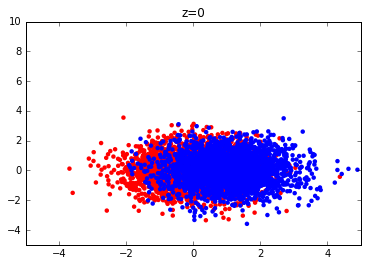

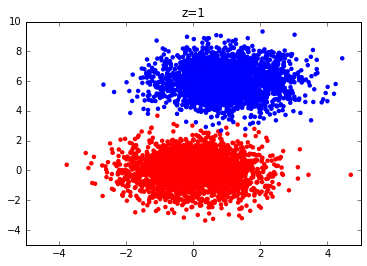

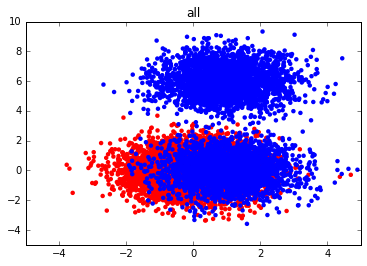

In [5]:
plt.title("z=0")
plt.scatter(X0[y0==0, 0], X0[y0==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X0[y0==1, 0], X0[y0==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-5, 5)
plt.ylim(-5, 10)
plt.show()

plt.title("z=1")
plt.scatter(X1[y1==0, 0], X1[y1==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X1[y1==1, 0], X1[y1==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-5, 5)
plt.ylim(-5, 10)
plt.show()

plt.title("all")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-5, 5)
plt.ylim(-5, 10)
plt.show()

In [134]:
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(24, activation="relu")(inputs)
Dx = Dense(24, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

Rx = D(inputs)
Rx = Dense(24, activation="relu")(Rx)
Rx = Dense(24, activation="relu")(Rx)
Rx = Dense(1, activation="sigmoid")(Rx)
R = Model(input=[inputs], output=[Rx])

In [135]:
from keras.optimizers import Adam, SGD

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        y_true = y_true.ravel()
        y_pred = y_pred.ravel()
        return c * ((1.0 - y_true) * (K.log(1.0 - y_pred)) + (y_true) * (K.log(y_pred))) 

    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        z_true = z_true.ravel()
        z_pred = z_pred.ravel()
        return c * ((1.0 - z_true) * (K.log(1.0 - z_pred)) + (z_true) * (K.log(z_pred)))
    
    return loss_R

opt_DRf = SGD(lr=10e-3, momentum=0.1)
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
DRf.compile(loss=[make_loss_D(c=-1.0), 
                  make_loss_R(c=20.0)],   # compare with c=0.0, ie. when no there is no adversary
            optimizer=opt_DRf)

opt_DfR = SGD(lr=10e-3, momentum=0.1)
DfR = Model(input=[inputs], output=[R(inputs)])
DfR.compile(loss=[make_loss_R(c=-1.0)], 
            optimizer=opt_DfR)

In [136]:
DRf.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
model_43 (Model)                 (None, 1)             697         input_11[0][0]                   
____________________________________________________________________________________________________
model_44 (Model)                 (None, 1)             1370        input_11[0][0]                   
Total params: 2067
____________________________________________________________________________________________________


In [137]:
DfR.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
model_44 (Model)                 (None, 1)             1370        input_11[0][0]                   
Total params: 1370
____________________________________________________________________________________________________


In [138]:
DRf.predict(X[:3])

[array([[ 0.512169  ],
        [ 0.4682833 ],
        [ 0.48292592]], dtype=float32), array([[ 0.42356026],
        [ 0.43002021],
        [ 0.42786205]], dtype=float32)]

In [139]:
DfR.predict(X[:3])

array([[ 0.42356026],
       [ 0.43002021],
       [ 0.42786205]], dtype=float32)

In [140]:
# Pretraining
D.trainable = False
R.trainable = True
DfR.fit(X, z, nb_epoch=50)

Epoch 1/50
10000/10000 [==============================] - 0s - loss: 0.7007     
Epoch 2/50
10000/10000 [==============================] - 0s - loss: 0.6978     
Epoch 3/50
10000/10000 [==============================] - 0s - loss: 0.6970     
Epoch 4/50
10000/10000 [==============================] - 0s - loss: 0.6957     
Epoch 5/50
10000/10000 [==============================] - 0s - loss: 0.6951     
Epoch 6/50
10000/10000 [==============================] - 0s - loss: 0.6946     
Epoch 7/50
10000/10000 [==============================] - 0s - loss: 0.6940     
Epoch 8/50
10000/10000 [==============================] - 0s - loss: 0.6935     
Epoch 9/50
10000/10000 [==============================] - 0s - loss: 0.6929     
Epoch 10/50
10000/10000 [==============================] - 0s - loss: 0.6923     
Epoch 11/50
10000/10000 [==============================] - 0s - loss: 0.6918     
Epoch 12/50
10000/10000 [==============================] - 0s - loss: 0.6913     
Epoch 13/50
10000/10000 [

In [143]:
from IPython import display

def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    plt.title("iteration = %d" % i)
    
    for label, values in losses.items():
        plt.plot(range(len(values)), values, label=label)
        
    plt.legend(loc="best")
    plt.show()

In [144]:
losses = {"L_d": [], "L_r": [], "L_d - L_r": []}

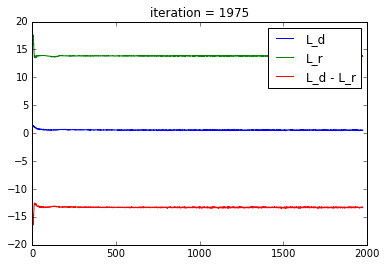

In [145]:
batch_size = 128

for i in range(2000):
    if i % 25 == 0:
        plot_losses(i, losses)
    
    # Fit D
    D.trainable = True
    R.trainable = False
    indices = np.random.permutation(len(X))[:batch_size]
    l = DRf.train_on_batch(X[indices], [y[indices], z[indices]])
    
    losses["L_d - L_r"].append(l[0][None][0])
    losses["L_d"].append(l[1][None][0])
    losses["L_r"].append(-l[2][None][0])
    
    # Fit R
    D.trainable = False
    R.trainable = True
#     DfR.fit(X, z, nb_epoch=3, verbose=0)
    
    for j in range(20):
        indices = np.random.permutation(len(X))[:batch_size]
        DfR.train_on_batch(X[indices], z[indices])

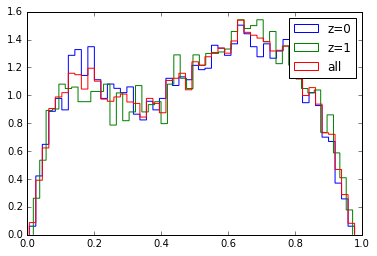

In [146]:
plt.hist(D.predict(X[z==0]), bins=50, normed=1, histtype="step", label="z=0")
plt.hist(D.predict(X[z==1]), bins=50, normed=1, histtype="step", label="z=1")
plt.hist(D.predict(X), bins=50, normed=1, histtype="step", label="all")
plt.legend()
plt.show()

In [147]:
X_test = np.random.rand(10000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 15. 
X_test[:, 1] -= 5.
y_pred = D.predict(X_test).ravel()

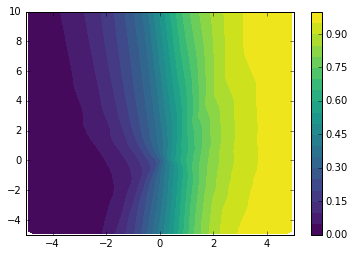

In [148]:
from matplotlib.mlab import griddata
xi = np.linspace(-5, 5., 100)
yi = np.linspace(-5, 10., 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp='linear')
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 